In [53]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
import os
import re
import collections
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
import numpy as np
torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'mps'

from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import OneCycleLR
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

In [4]:
input_file_path = 'data/full_shakespeare.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 4,573,338


In [5]:
vocab_size = 2000

# Define a BPE model
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer.decoder = decoders.ByteLevel()

# Trainer with desired vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>"])
# data should be an iterator over your text lines or documents
tokenizer.train_from_iterator([data], trainer=trainer)

# Encode and decode functions
def encode_bpe(text):
    return tokenizer.encode(text).ids

def decode_bpe(ids):
    return tokenizer.decode(ids)

# Example usage:
train_text = data[:int(len(data) * 0.9)]
val_text = data[int(len(data) * 0.9):]

train_tokens = encode_bpe(train_text)
val_tokens = encode_bpe(val_text)

import torch
train_data = torch.tensor(train_tokens)
val_data = torch.tensor(val_tokens)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")




train has 1,478,711 tokens
val has 163,429 tokens


In [56]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device, label_smoothing = None, focal_gamma = None, use_focal_loss=False):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}

    for split in ['train', 'val']:
        losses_by_type = {
            'ce_loss': torch.zeros(eval_iters),
        }
        if use_focal_loss:
            losses_by_type['f_loss'] = torch.zeros(eval_iters)
        
        if label_smoothing is None:
            label_smoothing = 0
        if focal_gamma is None:
            focal_gamma = 1

        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, ce_loss, f_loss = model(X, Y, label_smoothing = label_smoothing, focal_gamma=focal_gamma)
            losses_by_type['ce_loss'][k] = ce_loss.item()
            if use_focal_loss:
                losses_by_type['f_loss'][k] = f_loss.item()

        out[split] = {'ce_loss': losses_by_type['ce_loss'].mean().item()}
        if use_focal_loss:
            out[split]['f_loss'] = losses_by_type['f_loss'].mean().item()

    return out

In [50]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B, T, _ = x.shape
        K = self.head_size
        key = self.key(x)
        query = self.query(x)
        value = self.value(x)

        attn_scores = query@key.transpose(-2, -1)
        causal_mask = self.tril[:T, :T][None, :, :]
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
        attn_weights = torch.softmax(attn_scores / (K ** 0.5), dim=-1)
        return attn_weights@value

class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.vocab_size = vocab_size
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_ids = token_ids.clone()
        for t in range(max_new_tokens):
            logits = self(new_token_ids)
            new_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
            new_token_ids = torch.cat([new_token_ids, new_token], dim=1)
        return new_token_ids

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.lm_head = nn.Linear(embed_size*num_heads, embed_size)
        self.num_heads = num_heads

    def forward(self, x):
        # TODO, your code below
        B, T, _ = x.shape
        head_size = x.shape[-1] // self.num_heads
        head_outputs = [head(x) for head in self.heads]
        head_outputs = torch.cat(head_outputs, dim=-1)
        head_outputs = head_outputs.view(B, T, -1)
        return self.lm_head(head_outputs)

class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.multi_head_attention = MultiHeadAttention(context_window_size, num_heads, self.head_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        loss = None
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.multi_head_attention(x)
        logits = self.lm_head(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        for t in range(max_new_tokens):
            if token_ids.shape[1] > self.context_window_size:
                token_ids = token_ids[:, -self.context_window_size:]
            B, T = token_ids.shape
            logits, loss = self.forward(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, 1)
            token_ids = torch.cat([token_ids, new_token], dim=1)
        return token_ids

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size // num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

def focal_loss(logits, targets, gamma=2.0, alpha=1.0, reduction='mean'):
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    focal_factor = (1 - pt) ** gamma
    loss = alpha * focal_factor * ce_loss

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None, label_smoothing = None, focal_gamma = None):
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        logits = self.blocks(x)
        logits = self.ln_f(logits)
        logits = self.lm_head(logits)

        if targets is not None:
            if label_smoothing is None:
                ce_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
            else:
                ce_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), label_smoothing = label_smoothing)
            
            if focal_gamma is None:
                f_loss = focal_loss(logits.view(-1, logits.shape[-1]), targets.view(-1), gamma=0.3)
            else:
                f_loss = focal_loss(logits.view(-1, logits.shape[-1]), targets.view(-1), gamma=focal_gamma)

            return logits, ce_loss, f_loss
        else:
            # Return None for the loss values when targets is None
            return logits, None, None

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        self.eval()
        for _ in range(max_new_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]
            logits, _, _ = self(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_ids = torch.cat([token_ids, next_token], dim=1)
        self.train()
        return token_ids



In [80]:
def plot_loss_comparison(ce_losses, focal_losses, oos_loss, interval=100):
    """
    Plots a comparison of in-sample losses (cross-entropy and focal)
    with out-of-sample (OOS) loss, which is recorded every `interval` iterations.
    
    If the OOS loss stops before the end of the in-sample loss timeline, 
    the final OOS loss value is extended to the last iteration.
    
    Args:
      ce_losses: list or array of cross-entropy losses (recorded every iteration).
      focal_losses: list or array of focal losses (recorded every iteration).
      oos_loss: list or array of out-of-sample losses (recorded every `interval` iterations).
      interval: the interval at which oos_loss is computed (default: 100).
    """
    plt.figure(figsize=(18, 6))

    # --- Subplot 1: Loss Curves ---
    plt.subplot(1, 2, 1)
    iterations = np.arange(len(ce_losses))
    plt.plot(iterations, ce_losses, label='Cross-Entropy Loss')
    plt.plot(iterations, focal_losses, label='Focal Loss')
    
    # Generate x-coordinates for the OOS loss.
    # Assume oos_loss is recorded every 'interval' iterations.
    oos_iters = np.arange(0, len(ce_losses), interval)
    # If there are more x points than available oos_loss values, trim to match.
    min_length = min(len(oos_iters), len(oos_loss))
    oos_iters = oos_iters[:min_length]
    oos_loss_adjusted = np.array(oos_loss[:min_length])
    
    # If the last recorded oos loss does not reach the end, extend it.
    if oos_iters[-1] < len(ce_losses) - 1:
        oos_iters = np.append(oos_iters, len(ce_losses) - 1)
        oos_loss_adjusted = np.append(oos_loss_adjusted, oos_loss_adjusted[-1])
    
    # Plot the OOS loss as a step function.
    plt.step(oos_iters, oos_loss_adjusted, label='Out-of-Sample Loss', where='post', linewidth=2)
    
    plt.title('Loss Comparison Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # --- Subplot 2: Average Loss Comparison ---
    plt.subplot(1, 2, 2)
    # For in-sample losses, compute average over last 100 iterations (or all if fewer than 100)
    if len(ce_losses) >= 100:
        avg_ce = np.mean(ce_losses[-100:])
        avg_focal = np.mean(focal_losses[-100:])
    else:
        avg_ce = np.mean(ce_losses)
        avg_focal = np.mean(focal_losses)
    # For oos_loss, average over all available samples
    avg_oos = np.mean(oos_loss) if len(oos_loss) > 0 else 0

    plt.bar(['CE Loss', 'Focal Loss', 'OOS Loss'], [avg_ce, avg_focal, avg_oos])
    plt.title('Average Loss Comparison (Last 100 Iterations vs. OOS Loss)')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


In [81]:
hyperparam_list = {
    "smoothing": [0, 0.03, 0.1, 0.25],
    "focal_gammas": [0.3, 1, 1.7, 2.5]
}



Trying model with smoothing 0


  0%|          | 1/2001 [00:03<1:42:52,  3.09s/it]

step 0: train loss {'ce_loss': 7.716547012329102}, val loss {'ce_loss': 7.712482929229736}


 10%|█         | 201/2001 [00:34<30:43,  1.02s/it]

step 200: train loss {'ce_loss': 4.863089084625244}, val loss {'ce_loss': 4.964972972869873}


 20%|██        | 401/2001 [01:05<27:21,  1.03s/it]

step 400: train loss {'ce_loss': 4.440733432769775}, val loss {'ce_loss': 4.600752353668213}


 30%|███       | 601/2001 [01:36<23:55,  1.03s/it]

step 600: train loss {'ce_loss': 4.103551387786865}, val loss {'ce_loss': 4.3336992263793945}


 40%|████      | 801/2001 [02:07<20:27,  1.02s/it]

step 800: train loss {'ce_loss': 3.8280692100524902}, val loss {'ce_loss': 4.141571044921875}


 50%|█████     | 1001/2001 [02:38<17:01,  1.02s/it]

step 1000: train loss {'ce_loss': 3.6139960289001465}, val loss {'ce_loss': 3.9842352867126465}


 60%|██████    | 1201/2001 [03:08<13:39,  1.02s/it]

step 1200: train loss {'ce_loss': 3.4272024631500244}, val loss {'ce_loss': 3.877856492996216}


 70%|███████   | 1401/2001 [03:39<10:14,  1.02s/it]

step 1400: train loss {'ce_loss': 3.2407543659210205}, val loss {'ce_loss': 3.806095600128174}


 80%|████████  | 1601/2001 [04:10<06:49,  1.02s/it]

step 1600: train loss {'ce_loss': 3.077155113220215}, val loss {'ce_loss': 3.7728936672210693}


 90%|████████▉ | 1800/2001 [04:41<00:31,  6.39it/s]

step 1800: train loss {'ce_loss': 2.944384813308716}, val loss {'ce_loss': 3.7738547325134277}
Likely overfitting. Stopping early


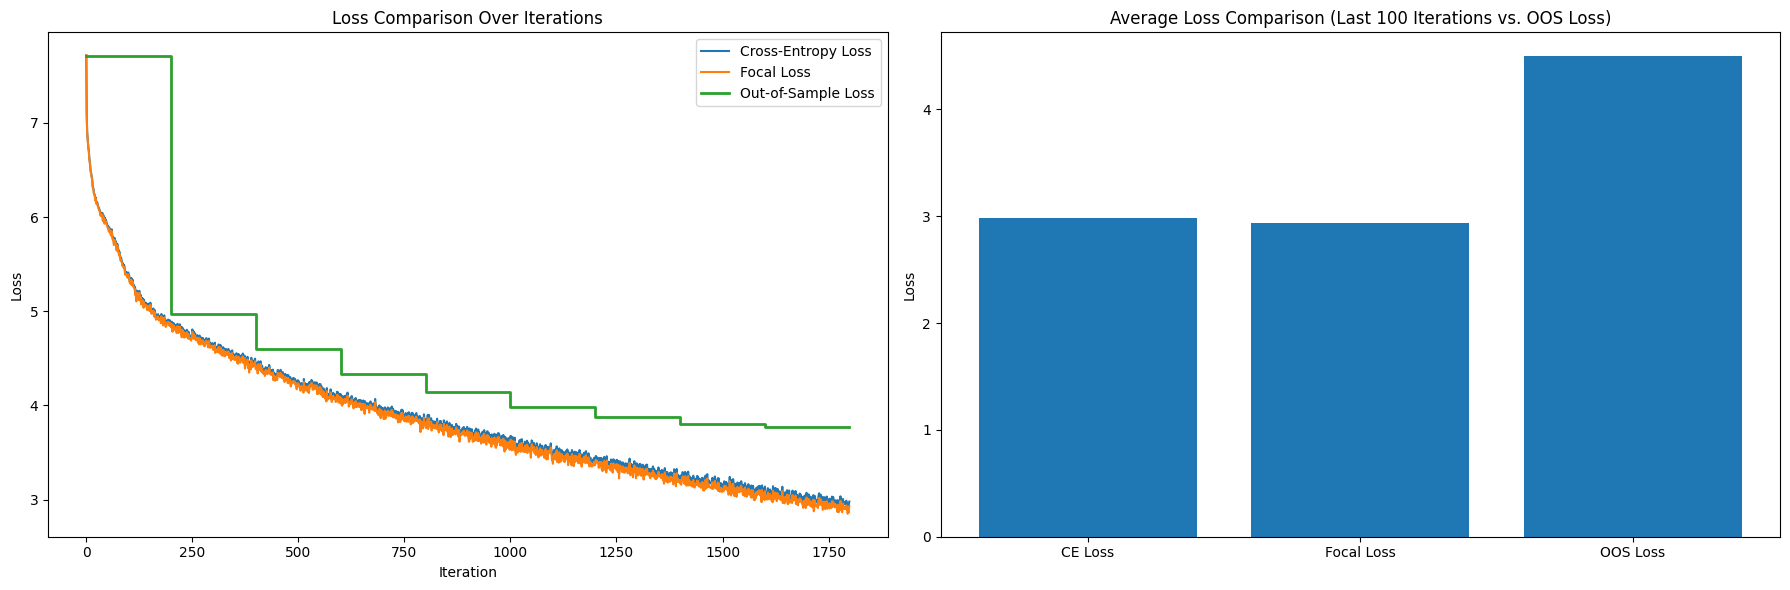



Trying model with smoothing 0.03


  0%|          | 1/2001 [00:03<1:43:21,  3.10s/it]

step 0: train loss {'ce_loss': 7.644141674041748}, val loss {'ce_loss': 7.645195484161377}


 10%|█         | 201/2001 [00:34<30:54,  1.03s/it]

step 200: train loss {'ce_loss': 5.070669174194336}, val loss {'ce_loss': 5.142589569091797}


 20%|██        | 401/2001 [01:05<27:22,  1.03s/it]

step 400: train loss {'ce_loss': 4.618478298187256}, val loss {'ce_loss': 4.7563042640686035}


 30%|███       | 601/2001 [01:36<23:57,  1.03s/it]

step 600: train loss {'ce_loss': 4.28109884262085}, val loss {'ce_loss': 4.492012023925781}


 40%|████      | 801/2001 [02:07<20:34,  1.03s/it]

step 800: train loss {'ce_loss': 4.0234551429748535}, val loss {'ce_loss': 4.3111114501953125}


 50%|█████     | 1001/2001 [02:38<17:07,  1.03s/it]

step 1000: train loss {'ce_loss': 3.8095924854278564}, val loss {'ce_loss': 4.172918319702148}


 60%|██████    | 1201/2001 [03:08<13:41,  1.03s/it]

step 1200: train loss {'ce_loss': 3.6169354915618896}, val loss {'ce_loss': 4.072469234466553}


 70%|███████   | 1401/2001 [03:39<10:16,  1.03s/it]

step 1400: train loss {'ce_loss': 3.4462661743164062}, val loss {'ce_loss': 4.006457328796387}


 80%|████████  | 1601/2001 [04:10<06:50,  1.03s/it]

step 1600: train loss {'ce_loss': 3.3162102699279785}, val loss {'ce_loss': 3.9703550338745117}


 90%|████████▉ | 1800/2001 [04:41<00:31,  6.39it/s]

step 1800: train loss {'ce_loss': 3.162429094314575}, val loss {'ce_loss': 3.9789252281188965}
Likely overfitting. Stopping early


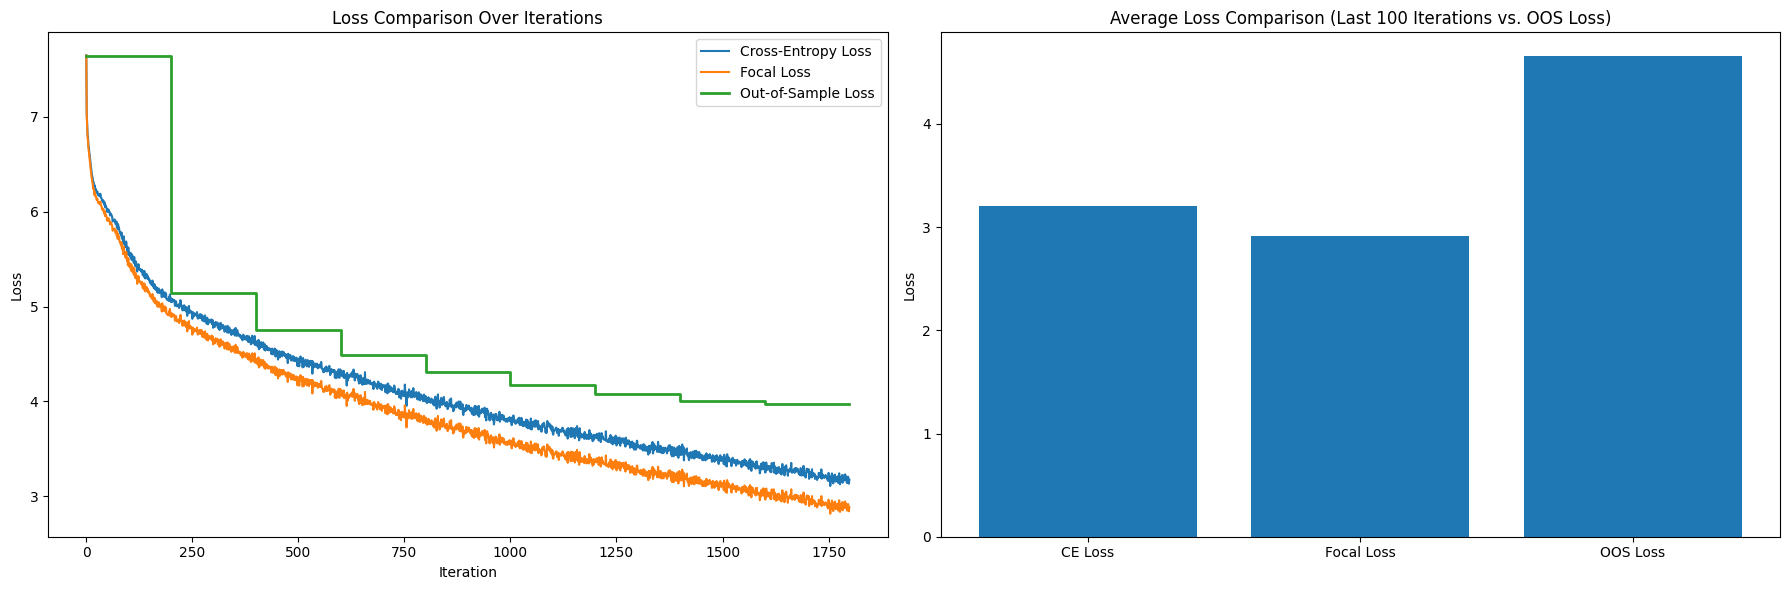



Trying model with smoothing 0.1


  0%|          | 1/2001 [00:03<1:43:02,  3.09s/it]

step 0: train loss {'ce_loss': 7.664391994476318}, val loss {'ce_loss': 7.665132999420166}


 10%|█         | 201/2001 [00:33<30:50,  1.03s/it]

step 200: train loss {'ce_loss': 5.39918327331543}, val loss {'ce_loss': 5.4614410400390625}


 20%|██        | 401/2001 [01:04<27:25,  1.03s/it]

step 400: train loss {'ce_loss': 4.9414448738098145}, val loss {'ce_loss': 5.070764541625977}


 30%|███       | 601/2001 [01:35<23:57,  1.03s/it]

step 600: train loss {'ce_loss': 4.6377787590026855}, val loss {'ce_loss': 4.829376220703125}


 40%|████      | 801/2001 [02:06<20:32,  1.03s/it]

step 800: train loss {'ce_loss': 4.397900104522705}, val loss {'ce_loss': 4.685108184814453}


 50%|█████     | 1001/2001 [02:37<17:09,  1.03s/it]

step 1000: train loss {'ce_loss': 4.200610160827637}, val loss {'ce_loss': 4.550726413726807}


 60%|██████    | 1201/2001 [03:08<13:42,  1.03s/it]

step 1200: train loss {'ce_loss': 4.041316509246826}, val loss {'ce_loss': 4.46883487701416}


 70%|███████   | 1401/2001 [03:38<10:17,  1.03s/it]

step 1400: train loss {'ce_loss': 3.9033141136169434}, val loss {'ce_loss': 4.421828269958496}


 80%|████████  | 1601/2001 [04:09<06:50,  1.03s/it]

step 1600: train loss {'ce_loss': 3.778763771057129}, val loss {'ce_loss': 4.384931564331055}


 90%|████████▉ | 1800/2001 [04:40<00:31,  6.42it/s]

step 1800: train loss {'ce_loss': 3.674166202545166}, val loss {'ce_loss': 4.394866943359375}
Likely overfitting. Stopping early


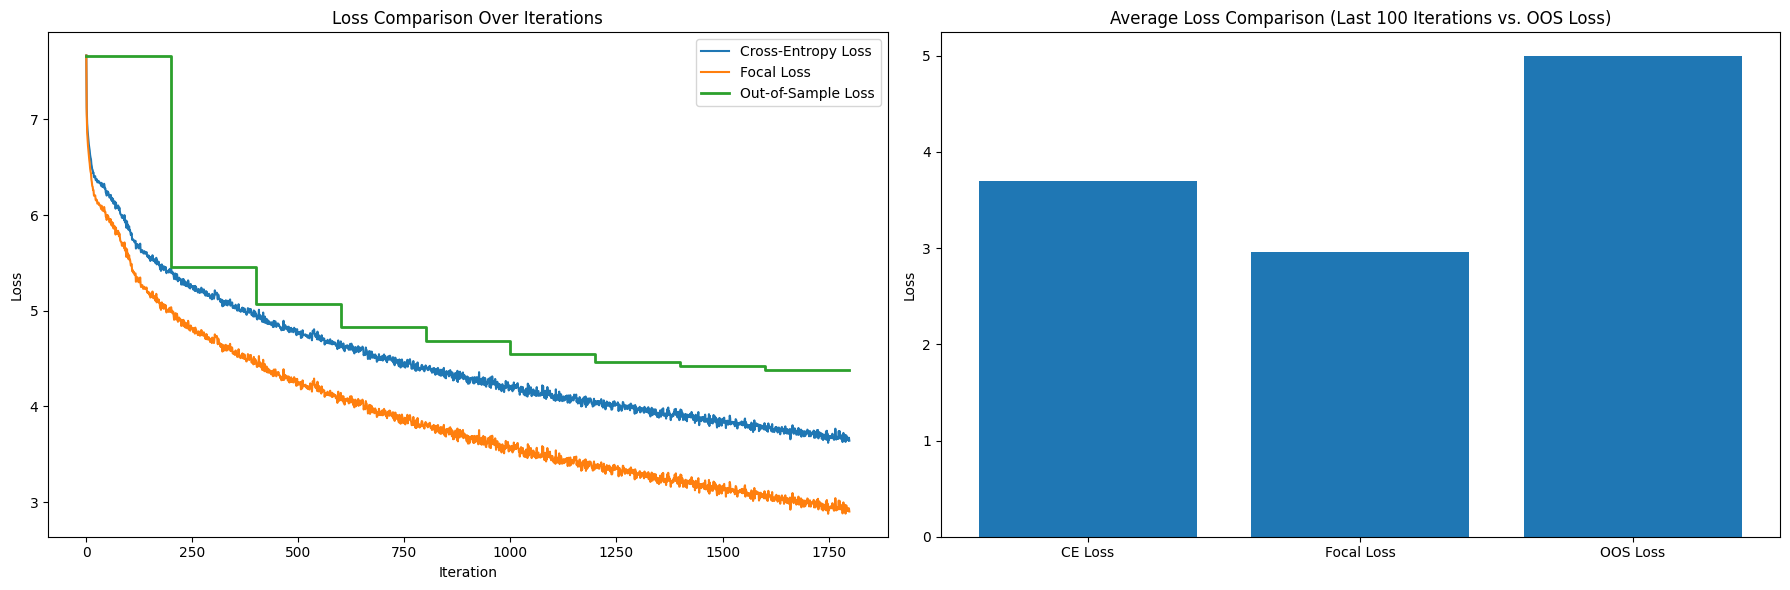



Trying model with smoothing 0.25


  0%|          | 1/2001 [00:03<1:43:34,  3.11s/it]

step 0: train loss {'ce_loss': 7.622818470001221}, val loss {'ce_loss': 7.629344463348389}


 10%|█         | 201/2001 [00:33<30:55,  1.03s/it]

step 200: train loss {'ce_loss': 5.8499836921691895}, val loss {'ce_loss': 5.918908596038818}


 20%|██        | 401/2001 [01:04<27:29,  1.03s/it]

step 400: train loss {'ce_loss': 5.5506157875061035}, val loss {'ce_loss': 5.669226169586182}


 30%|███       | 601/2001 [01:35<24:02,  1.03s/it]

step 600: train loss {'ce_loss': 5.312780857086182}, val loss {'ce_loss': 5.481651782989502}


 40%|████      | 801/2001 [02:06<20:33,  1.03s/it]

step 800: train loss {'ce_loss': 5.127386569976807}, val loss {'ce_loss': 5.354737758636475}


 50%|█████     | 1001/2001 [02:37<17:11,  1.03s/it]

step 1000: train loss {'ce_loss': 4.9652934074401855}, val loss {'ce_loss': 5.2537384033203125}


 60%|██████    | 1201/2001 [03:08<13:45,  1.03s/it]

step 1200: train loss {'ce_loss': 4.851672649383545}, val loss {'ce_loss': 5.181358814239502}


 70%|███████   | 1401/2001 [03:39<10:18,  1.03s/it]

step 1400: train loss {'ce_loss': 4.7434306144714355}, val loss {'ce_loss': 5.143204212188721}


 80%|████████  | 1601/2001 [04:10<06:52,  1.03s/it]

step 1600: train loss {'ce_loss': 4.643054485321045}, val loss {'ce_loss': 5.131218433380127}


 90%|████████▉ | 1800/2001 [04:41<00:31,  6.40it/s]

step 1800: train loss {'ce_loss': 4.540086269378662}, val loss {'ce_loss': 5.145577907562256}
Likely overfitting. Stopping early


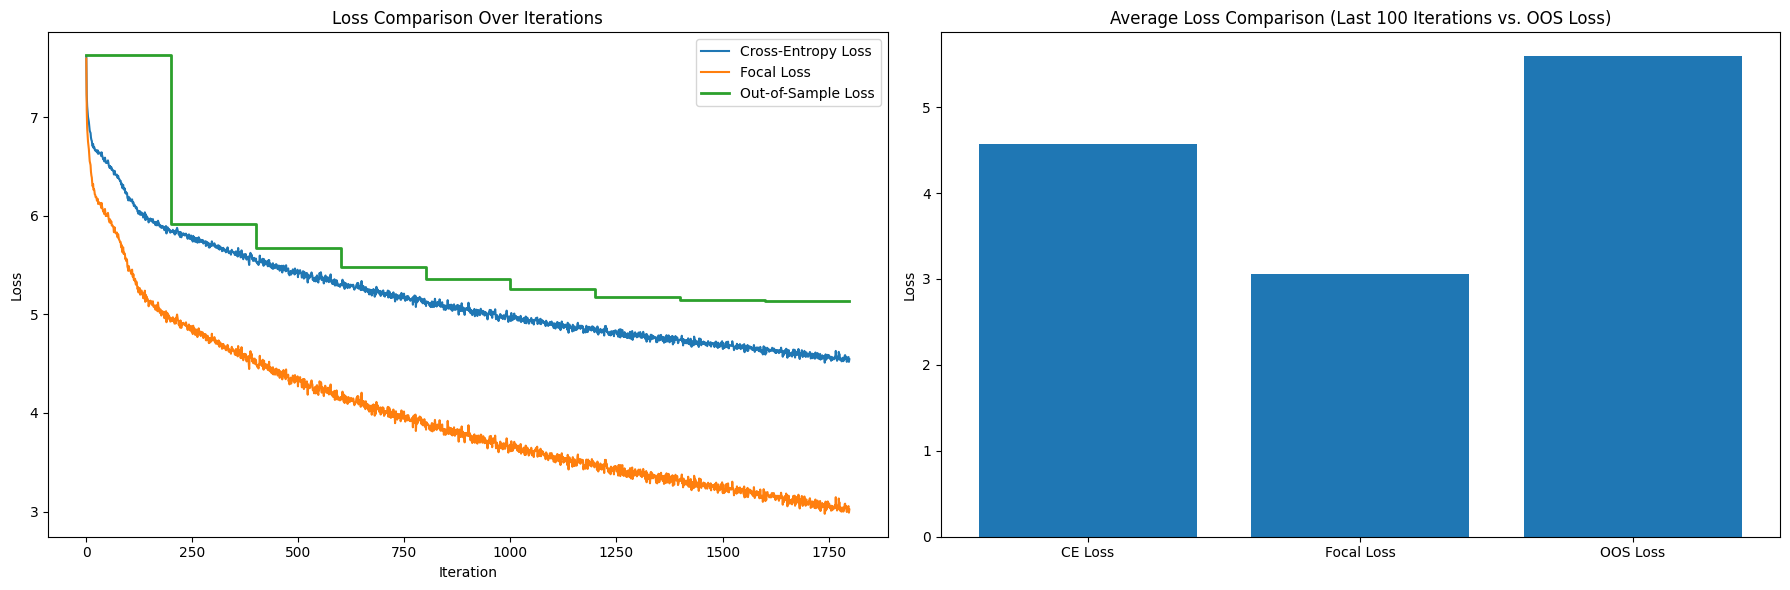

In [82]:
for smoothing in hyperparam_list["smoothing"]:
    print(f"\n\nTrying model with smoothing {smoothing}")
    tlm = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
    tlm = tlm.to(device)

    learning_rate = 2e-4
    optimizer = optim.Adam(tlm.parameters(), lr=learning_rate)
    eval_interval = 200

    f_loss_list = []
    ce_loss_list = []
    oos_ce_losses = []

    best_oos_loss = np.inf

    for it in tqdm(range(LARGE_ITERS + 1)):
        optimizer.zero_grad()
        # Evaluate
        if it % eval_interval == 0:
            losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, label_smoothing=smoothing)
            print(f"step {it}: train loss {losses['train']}, val loss {losses['val']}")
            oos_ce_losses.append(losses['val']['ce_loss'])

            if losses['val']['ce_loss'] > best_oos_loss:
                print("Likely overfitting. Stopping early")
                break
            else:
                best_oos_loss = losses['val']['ce_loss']
        
        # Forward/backward/update
        xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size = 128)
        logits, ce_loss, f_loss = tlm(xb, yb, label_smoothing=smoothing)
        
        ce_loss.backward()

        optimizer.step()
        f_loss_list.append(f_loss.item())
        ce_loss_list.append(ce_loss.item())

    plot_loss_comparison(ce_loss_list, f_loss_list, oos_ce_losses, interval=eval_interval)

    torch.save(tlm, f'trained_smoothing_{smoothing}.pth')

In [ ]:
for focal_gamma in hyperparam_list["focal_gammas"]:
    print(f"\n\nTrying model with focal gamma {focal_gamma}")
    tlm = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
    tlm = tlm.to(device)

    learning_rate = 2e-4
    optimizer = optim.Adam(tlm.parameters(), lr=learning_rate)
    eval_interval = 200

    f_loss_list = []
    ce_loss_list = []
    oos_f_losses = []

    best_oos_loss = np.inf

    for it in tqdm(range(LARGE_ITERS + 1)):
        optimizer.zero_grad()
        # Evaluate
        if it % eval_interval == 0:
            losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, focal_gamma = focal_gamma, use_focal_loss=True)
            print(f"step {it}: train loss {losses['train']}, val loss {losses['val']}")

            oos_f_losses.append(losses['val']['f_loss'])

            if losses['val']['f_loss'] > best_oos_loss:
                print("Likely overfitting. Stopping early")
                break
            else:
                best_oos_loss = losses['val']['f_loss']
        
        # Forward/backward/update
        xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size = 128)
        logits, ce_loss, f_loss = tlm(xb, yb, focal_gamma=focal_gamma)
        
        f_loss.backward()

        optimizer.step()
        f_loss_list.append(f_loss.item())
        ce_loss_list.append(ce_loss.item())

    plot_loss_comparison(ce_loss_list, f_loss_list, oos_f_losses, interval=eval_interval)

    torch.save(tlm, f'trained_focal_{focal_gamma}.pth')



Trying model with focal gamma 0.3


  0%|          | 1/2001 [00:03<1:43:10,  3.10s/it]

step 0: train loss {'ce_loss': 7.6999125480651855, 'f_loss': 7.698803901672363}, val loss {'ce_loss': 7.698248386383057, 'f_loss': 7.6971354484558105}


 10%|▉         | 200/2001 [00:30<04:08,  7.24it/s]

In [ ]:
learning_rate = 3e-4
optimizer = optim.Adam(tlm.parameters(), lr=learning_rate)
eval_interval = 250

In [ ]:
f_loss_list = []
ce_loss_list = []
for it in tqdm(range(2000)):
    # Evaluate
    if it % eval_interval == 0:
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True)
        print(f"step {it}: train loss {losses['train']}, val loss {losses['val']}")
    
    # Forward/backward/update
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size = 128)
    logits, ce_loss, f_loss = tlm(xb, yb)
    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    f_loss_list.append(f_loss.item())
    ce_loss_list.append(ce_loss.item())

print("final CE training loss =", ce_loss_list[-1])
print("final F training loss =", f_loss_list[-1])

  0%|          | 1/2000 [00:03<1:43:02,  3.09s/it]

step 0: train loss {'ce_loss': 6.422837734222412, 'f_loss': 6.4069037437438965}, val loss {'ce_loss': 6.445936679840088, 'f_loss': 6.430345058441162}
LR: [3.9999999999999996e-05]


 25%|██▌       | 501/2000 [01:15<26:03,  1.04s/it]

step 500: train loss {'ce_loss': 4.482242584228516, 'f_loss': 4.435137748718262}, val loss {'ce_loss': 4.656986236572266, 'f_loss': 4.612618923187256}
LR: [0.0009367371659577804]


 50%|█████     | 1001/2000 [02:28<17:06,  1.03s/it]

step 1000: train loss {'ce_loss': 3.3105263710021973, 'f_loss': 3.2391104698181152}, val loss {'ce_loss': 3.821786880493164, 'f_loss': 3.7570786476135254}
LR: [0.0008108676604285944]


 75%|███████▌  | 1501/2000 [03:41<08:31,  1.03s/it]

step 1500: train loss {'ce_loss': 2.716792583465576, 'f_loss': 2.635136127471924}, val loss {'ce_loss': 3.715622663497925, 'f_loss': 3.649519681930542}
LR: [0.00028205066459905157]


100%|██████████| 2000/2000 [04:50<00:00,  6.89it/s]

final CE training loss = 2.4061789512634277
final F training loss = 2.3197169303894043


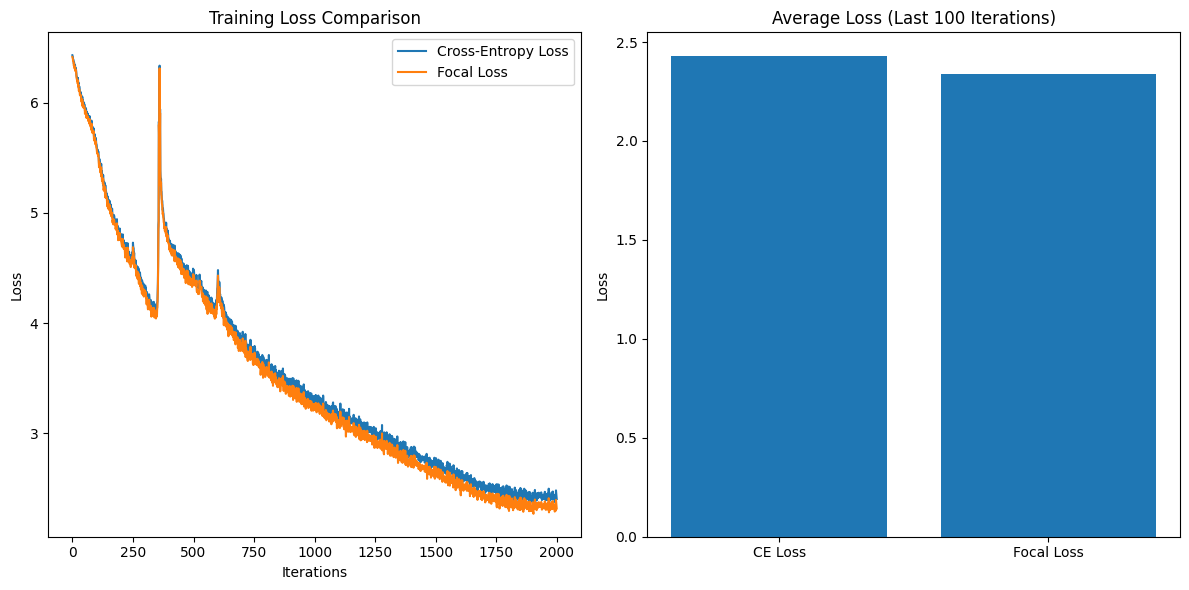

In [24]:
# Plot losses vs. epoch
plot_loss_comparison(ce_loss_list, f_loss_list)

In [16]:
estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True)

{'train': {'ce_loss': 3.4172675609588623, 'f_loss': 3.3467981815338135},
 'val': {'ce_loss': 3.878727912902832, 'f_loss': 3.8162343502044678}}

In [12]:
f_loss_list = []
ce_loss_list = []
for it in tqdm(range(LARGE_ITERS)):
    # Evaluate
    if it % eval_interval == 0:
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True)
        print(f"step {it}: train loss {losses['train']}, val loss {losses['val']}")
    
    # Forward/backward/update
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size = 64)
    logits, ce_loss, f_loss = tlm(xb, yb)
    optimizer.zero_grad()
    f_loss.backward()
    optimizer.step()
    f_loss_list.append(f_loss.item())
    ce_loss_list.append(ce_loss.item())

print("final CE training loss =", ce_loss_list[-1])
print("final F training loss =", f_loss_list[-1])

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0: train loss {'ce_loss': 7.650057792663574, 'f_loss': 7.648144721984863}, val loss {'ce_loss': 7.6523051261901855, 'f_loss': 7.650395393371582}


 10%|█         | 200/2000 [02:33<19:30,  1.54it/s] 

step 200: train loss {'ce_loss': 5.111303329467773, 'f_loss': 5.072350025177002}, val loss {'ce_loss': 5.183755397796631, 'f_loss': 5.145900726318359}


 18%|█▊        | 350/2000 [04:34<21:33,  1.28it/s]  


KeyboardInterrupt: 

In [26]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())

In [27]:
print(decode_bpe(uncond_gen))

force
Prangery-nobed, and mine own; and--

KING LEAR:
Good lad defence, infinite; one; lay'st thou down
Thy sack in the angry, and neither a slail better;
And throw him out on this, or do you rob
To do thee spies, to whiles, seeming changed,
And with his oured tongues, that hastys thress
May make her big and deliver'd easy.
Hath not this done well? I call here open,
O'er-adbeyGrappaigo: lay away
The ancient of things to do each one: ho!

REHAN:
'Tis so, fellow. 'tis not with us: you are so.

EARL OF DANGOR PANCESTER:
You are with me, sirs: go you to blush
The rein: we'll kill you.

HOTSPUR:

Just Romeo! wilt thou go, let me be the seashards
And pay


In [28]:
xb, yb = get_batch(split='train', context_window_size=CONTEXT_WINDOW_SIZE, device=device)

In [29]:
decode_bpe(tlm.generate(xb[0:1], max_new_tokens=10).tolist()[0])

'? As Caesar loved me, I weep for him;\nas he was fortunate, I rejoice at it; as he was\nvaliant, I honour him: but, as he was ambitious, I\nslew him. There is tears for his love; joy for his\nfortune; honour for his valour; and death for his\nambition. Who is here so base that would be a\nbondman? If any, speak; for him have I offended.\nWho is here so rude that would not be a Roman? If\nany, speak; for him have I offended. Who is here so\nvile that will not love his country? If any, speak;\nfor him have I offended. I pause for a reply.\n\nAll:\nNone, Brutus, none.\n\nBRUTUS:\nThen none have I offended. I have done no more to\nCaesar than you shall do to Brutus. The question of\nhis death is enrolled in the Capitol; his gloss is\nwith the present temple and'

## M-Loss

In [38]:
def m_loss(logits, targets, alpha=1.0, epsilon=1e-5, clamp_min=0.05, clamp_max=0.95, reduction='mean'):
    """
    Improved M Loss function with better numerical stability for language modeling.

    Args:
        logits: Tensor of shape (batch_size * seq_len, vocab_size)
        targets: Tensor of shape (batch_size * seq_len)
        alpha: Weighting factor
        epsilon: Small constant to prevent division by zero
        clamp_min: Minimum probability value to prevent extreme values
        clamp_max: Maximum probability value to prevent extreme values
        reduction: 'mean' or 'sum'

    Returns:
        Loss value
    """
    # Convert targets to one-hot encoding
    vocab_size = logits.size(-1)
    one_hot = F.one_hot(targets, num_classes=vocab_size).float()

    # Get predicted probabilities with softmax and clamp to avoid extreme values
    probs = F.softmax(logits, dim=-1)
    probs = torch.clamp(probs, min=clamp_min, max=clamp_max)

    # Calculate stabilized M loss
    # Instead of direct division, use log-space operations
    log_probs = torch.log(probs + epsilon)
    log_inv_probs = torch.log(1 - probs + epsilon)

    # Calculate components in log space to avoid numerical issues
    pos_term = one_hot * torch.exp(torch.clamp(-log_probs, max=10))
    neg_term = (1 - one_hot) * torch.exp(torch.clamp(-log_inv_probs, max=10))

    # Combine terms with a smooth transition
    m_loss_values = pos_term + neg_term - 1

    # Apply alpha weighting and reduce
    loss = alpha * m_loss_values.sum(dim=-1)

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

In [45]:
class TransformerLM_losstest(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        logits = self.blocks(x)
        logits = self.ln_f(logits)
        logits = self.lm_head(logits)

        if targets is not None:
            ce_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
            f_loss = focal_loss(logits.view(-1, logits.shape[-1]), targets.view(-1), gamma=0.5, alpha=1.0)
            m_loss_val = m_loss(logits.view(-1, logits.shape[-1]), targets.view(-1))
            return logits, ce_loss, f_loss, m_loss_val
        else:
            # Return None for loss values during inference
            return logits, None, None, None

   # 3. Update the generate method to handle the new return values
    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        self.eval()
        for _ in range(max_new_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]
            logits, _, _, _ = self(token_ids)  # Unpack four values now
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_ids = torch.cat([token_ids, next_token], dim=1)
        self.train()
        return token_ids


In [46]:
# 4. Update the estimate_loss function to handle M Loss
@torch.no_grad()
def estimate_losstest(model, eval_iters, context_window_size, device, use_focal_loss=False, use_m_loss=False):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses_by_type = {
            'ce_loss': torch.zeros(eval_iters),
        }
        if use_focal_loss:
            losses_by_type['f_loss'] = torch.zeros(eval_iters)
        if use_m_loss:
            losses_by_type['m_loss'] = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, ce_loss, f_loss, m_loss_val = model(X, Y)
            losses_by_type['ce_loss'][k] = ce_loss.item()
            if use_focal_loss:
                losses_by_type['f_loss'][k] = f_loss.item()
            if use_m_loss:
                losses_by_type['m_loss'][k] = m_loss_val.item()

        out[split] = {'ce_loss': losses_by_type['ce_loss'].mean().item()}
        if use_focal_loss:
            out[split]['f_loss'] = losses_by_type['f_loss'].mean().item()
        if use_m_loss:
            out[split]['m_loss'] = losses_by_type['m_loss'].mean().item()

    return out


In [47]:
trans_test = TransformerLM_losstest(vocab_size, CONTEXT_WINDOW_SIZE)
tlm_test = trans_test.to(device)
learning_rate = 1e-4
# TODO, your code below

optimizer = optim.Adam(tlm_test.parameters(), lr=learning_rate)

eval_interval = 200

In [51]:
# 5. Training loop with M Loss
m_loss_list = []
ce_loss_list = []
for it in tqdm(range(LARGE_ITERS)):
    # Evaluate
    if it % eval_interval == 0:
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True)
        print(f"step {it}: train loss {losses['train']}, val loss {losses['val']}")

    # Forward/backward/update
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)
    logits, ce_loss, f_loss = tlm(xb, yb)
    optimizer.zero_grad()
    f_loss.backward()  # Use M loss for optimization
    optimizer.step()
    ce_loss_list.append(ce_loss.item())

print("final CE training loss =", ce_loss_list[-1])
print("final M training loss =", m_loss_list[-1])


  0%|          | 0/2000 [00:00<?, ?it/s]

step 0: train loss {'ce_loss': 2.663043260574341, 'f_loss': 2.5754470825195312}, val loss {'ce_loss': 3.8241536617279053, 'f_loss': 3.7587201595306396}


  1%|          | 16/2000 [00:33<1:10:14,  2.12s/it]


KeyboardInterrupt: 

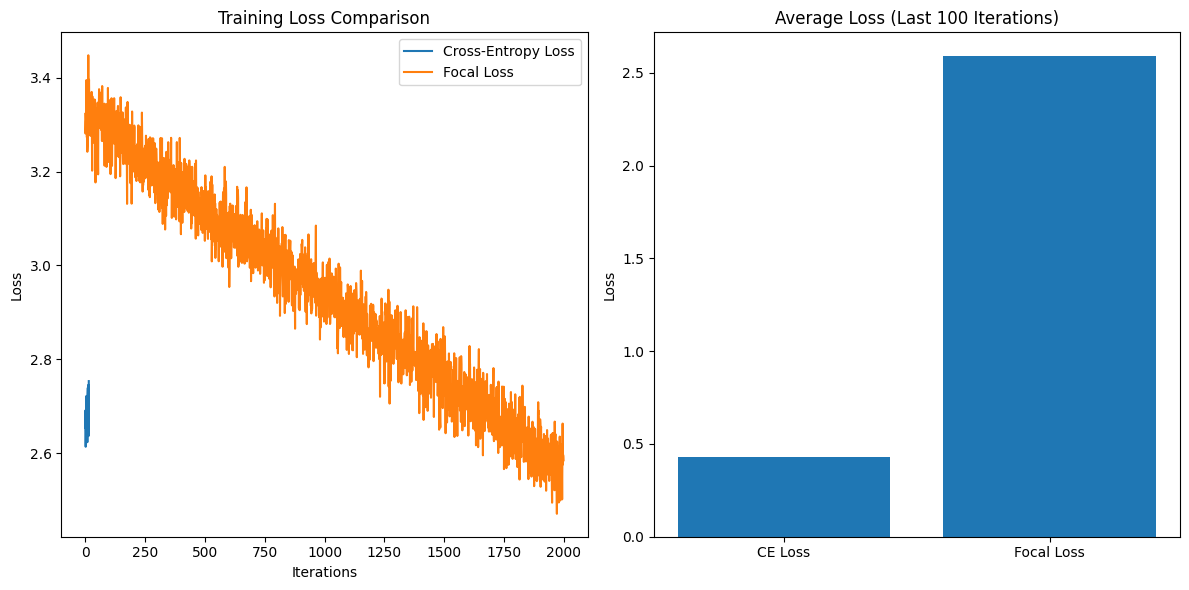